<a href="https://colab.research.google.com/github/isandrade-udea/LabIA/blob/main/NewFaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconocimiento facial** 😎

Este código implementa un sistema de reconocimiento facial utilizando la biblioteca facenet_pytorch y otras herramientas de procesamiento de imágenes y manejo de datos en Python. La funcion `detectar_cara ` tiene como entradas la ruta de la imagen donde estan las personas a identificar y un dataset que contiene los nombre y embbedings de personas que han sido identificadas,para:

* Detectar las caras en la imagen utilizando MTCNN.
* Calcular los embeddings faciales de las caras detectadas utilizando InceptionResnetV1.
* Comparar los embeddings calculados con las referencias existentes en el DataFrame utilizando similitud coseno. Si no se encuentra una coincidencia con suficiente similitud, muestra la cara no identificada y solicita al usuario ingresar la identidad.
* Actualizar el DataFrame de referencias con nuevas identidades proporcionadas por el usuario.


## Librerías necesarias

In [ ]:
!pip install facenet_pytorch

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import PIL
import os
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity

##Montando la unidad de google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargando df de referencia

In [20]:
df_referencia= pd.read_excel('/content/drive/MyDrive/SENA/Sena2024/Investigacion/FaceRecognition/dic_referencia.xlsx')
df_referencia.head(13)

,Identidad,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,HaleyDunphy,-0.022707,0.009983,0.044864,-0.047747,0.012819,-0.001801,0.016220,-0.106964,0.042296,...,0.001090,0.066654,0.016722,-0.037480,-0.025443,0.034158,-0.023925,0.001079,0.029827,0.009927
1,GloriaPritchett,0.011648,0.006462,-0.011545,-0.005980,0.048314,-0.050040,0.041604,-0.063167,-0.003533,...,0.016160,0.046353,0.011444,0.029175,0.006449,0.069000,-0.008343,-0.007011,-0.009228,-0.032546
2,PhilDunphy,-0.070324,0.001567,-0.038979,-0.009452,-0.018962,0.032783,0.013281,-0.002328,0.006942,...,0.033218,0.011661,0.007408,0.009384,-0.002643,0.021374,0.065474,0.075011,-0.108417,-0.077682
3,ClaireDunphy,-0.010425,0.009889,0.061048,-0.015764,0.019505,-0.015885,0.008130,-0.028694,0.014140,...,-0.024719,0.053336,0.002585,-0.056183,-0.011989,-0.021711,0.034491,0.027680,-0.054785,-0.041122
4,AlexDunphy,0.021710,0.051558,-0.006790,-0.017235,-0.034540,-0.026733,0.024390,-0.011185,0.083697,...,0.056812,0.095142,0.029530,-0.013640,0.013862,-0.010232,-0.013535,-0.071267,-0.035070,0.013210
5,LukeDunphy,0.030700,-0.004186,0.044523,0.015145,0.010612,-0.001348,-0.057052,-0.020034,0.056037,...,0.025833,-0.023824,0.025408,-0.020880,-0.014168,-0.031011,-0.020488,0.004335,-0.003357,0.003242
6,JayPritchett,0.004980,0.018897,-0.021305,-0.008709,-0.037535,-0.078557,-0.000223,0.022550,0.067375,...,0.028654,-0.027667,0.119657,0.003484,0.017197,0.022836,-0.044972,-0.026736,0.063584,0.011282
7,JoePritchett,-0.037053,-0.016128,0.018344,0.012569,0.073362,0.001878,-0.009959,-0.059406,0.041897,...,0.004484,-0.031171,0.036276,0.025330,0.032281,-0.038395,0.006515,-0.071290,0.049280,0.020273
8,MannyDelgado,0.003423,0.051696,0.001663,0.017171,-0.026559,-0.005772,0.006538,-0.008965,0.031943,...,0.052331,0.014699,-0.023666,-0.016164,-0.052937,0.032645,0.017571,-0.049459,-0.035738,0.026185
9,MitchellPritchett,0.025352,-0.011718,0.008287,-0.090398,-0.102610,-0.008475,-0.019798,0.061902,-0.032645,...,-0.014074,0.004037,0.013989,-0.024566,-0.053153,0.078927,-0.039419,0.064202,-0.047853,-0.078749


## Detector y codificador de caras

In [21]:
# Detectar si se dispone de GPU cuda
# ==============================================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Detector MTCNN
# ==============================================================================
detector = MTCNN(
    keep_all=True,  # Detectar todas las caras en la imagen
    post_process=False,
    min_face_size=40,
    thresholds=[0.6, 0.7, 0.7],
    device=device
)

# Modelo para hacer el embedding de las caras
# ==============================================================================
encoder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

## Función para detectar cara de una imagen

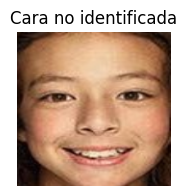

Ingrese la identidad de la persona (o 'no person' para descartar): Lily Tucker-Pritchett


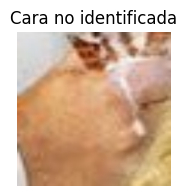

Ingrese la identidad de la persona (o 'no person' para descartar): no person


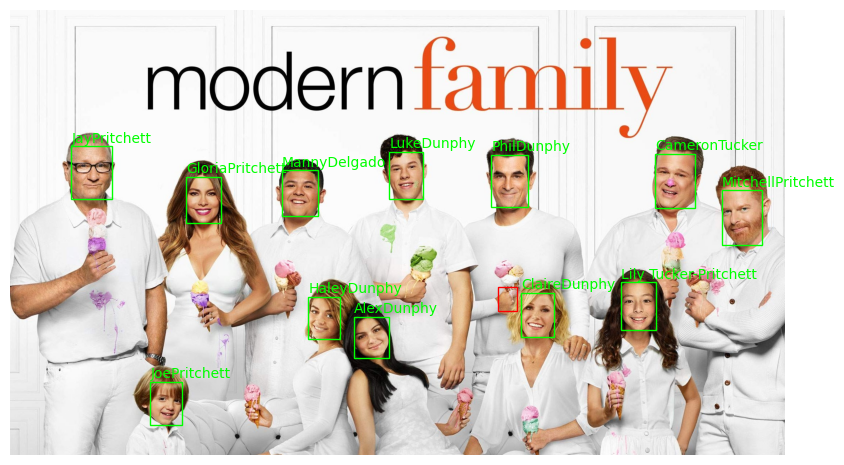

In [22]:
def detectar_cara(path_imagen, df_referencia, threshold_similaridad: float = 0.6, ax=None):

    # Lectura de imágenes
    # ==========================================================================
    imagen = Image.open(path_imagen)

    # Convertir RGBA a RGB si es necesario
    #===========================================================================
    if np.array(imagen).shape[2] == 4:
        imagen = np.array(imagen)[:, :, :3]
        imagen = Image.fromarray(imagen)

    # Detectar las caras en la imagen
    faces = detector(imagen)

    # Volver a detectar las caras en la imagen
    # Se utiliza nuevamente el detector para obtener las caras detectadas,
    # en este caso se guarda en 'imagenf', para usarla luego al mostrar
    # las caras no identificadas.
    imagenf = detector(imagen)

    # Detección de bounding box y landmarks
    # ==========================================================================
    bboxes, probs, landmarks = detector.detect(imagen, landmarks=True)

    if faces is None or len(faces) == 0:
        raise Exception("No se detectaron caras en la imagen.")

    # Normalizar los valores de los píxeles a [0, 1]
    faces = faces.float() / 255.0

    # Calculo de embeddings
    embeddings = encoder(faces).detach().cpu().numpy()

    identidades = []

    # Convertir el DataFrame a un diccionario temporal para cálculo de similitudes
    dic_referencia = df_referencia.set_index('Identidad').T.to_dict('list')

    for i in range(embeddings.shape[0]):
        # Se calcula la similitud con cada uno de los perfiles de referencia.
        similitudes = {}
        for key, value in dic_referencia.items():
            # Se calcula la similitud coseno entre el embedding actual y el embedding de referencia
            similitud = cosine_similarity(embeddings[i].reshape(1, -1), np.array(value).reshape(1, -1))[0, 0]
            similitudes[key] = similitud

        # Se identifica la persona de mayor similitud.
        identidad = max(similitudes, key=similitudes.get)
        # Si la similitud < threshold_similaridad, se etiqueta como None
        if similitudes[identidad] < threshold_similaridad:
            identidad = None

        if identidad is None:
            # Mostrar la imagen de la cara no identificada
            plt.figure(figsize=(2, 2))
            plt.imshow(imagenf[i].permute(1, 2, 0).int().numpy())
            plt.title("Cara no identificada")
            plt.axis('off')
            plt.show(block=False)
            plt.pause(1)  # Pausa para asegurar que la imagen se muestre

            # Pedir la identidad al usuario
            nueva_identidad = input("Ingrese la identidad de la persona (o 'no person' para descartar): ")

            if nueva_identidad.lower() != 'no person':
                # Actualizar el DataFrame de referencias con la nueva identidad
                nueva_fila = pd.DataFrame([[nueva_identidad] + embeddings[i].tolist()], columns=df_referencia.columns)
                df_referencia = pd.concat([df_referencia, nueva_fila], ignore_index=True)

                # Asignar la nueva identidad
                identidad = nueva_identidad

            # Cerrar la ventana de la imagen después de ingresar la identidad
            plt.close()

        identidades.append(identidad)

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    fig, ax = plt.subplots(figsize=(10, 6))

    if isinstance(imagen, Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255

    ax.imshow(imagen)
    ax.axis('off')

    if len(bboxes) > 0:

        for i, bbox in enumerate(bboxes):
            if identidades[i] is not None:
                rect = plt.Rectangle(
                    xy=(bbox[0], bbox[1]),
                    width=bbox[2] - bbox[0],
                    height=bbox[3] - bbox[1],
                    linewidth=1,
                    edgecolor='lime',
                    facecolor='none'
                )

                ax.add_patch(rect)

                ax.text(
                    x=bbox[0],
                    y=bbox[1] - 10,
                    s=identidades[i],
                    fontsize=10,
                    color='lime'
                )
            else:
                rect = plt.Rectangle(
                    xy=(bbox[0], bbox[1]),
                    width=bbox[2] - bbox[0],
                    height=bbox[3] - bbox[1],
                    linewidth=1,
                    edgecolor='red',
                    facecolor='none'
                )

                ax.add_patch(rect)

        plt.show()

    return df_referencia


# Ruta de la imagen a identificar
path_imagen_a_identificar = "/content/drive/MyDrive/SENA/Sena2024/Investigacion/FaceRecognition/modern-family.jpg"

# Identificar a la persona en la imagen y actualizar el DataFrame
df_referencia_actualizado = detectar_cara(path_imagen_a_identificar, df_referencia)

# Guardar el DataFrame actualizado en un archivo CSV
#df_referencia_actualizado.to_csv('dic_referencia_actualizado.csv', index=False)


In [23]:
df_referencia_actualizado.head(13)

,Identidad,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,HaleyDunphy,-0.022707,0.009983,0.044864,-0.047747,0.012819,-0.001801,0.016220,-0.106964,0.042296,...,0.001090,0.066654,0.016722,-0.037480,-0.025443,0.034158,-0.023925,0.001079,0.029827,0.009927
1,GloriaPritchett,0.011648,0.006462,-0.011545,-0.005980,0.048314,-0.050040,0.041604,-0.063167,-0.003533,...,0.016160,0.046353,0.011444,0.029175,0.006449,0.069000,-0.008343,-0.007011,-0.009228,-0.032546
2,PhilDunphy,-0.070324,0.001567,-0.038979,-0.009452,-0.018962,0.032783,0.013281,-0.002328,0.006942,...,0.033218,0.011661,0.007408,0.009384,-0.002643,0.021374,0.065474,0.075011,-0.108417,-0.077682
3,ClaireDunphy,-0.010425,0.009889,0.061048,-0.015764,0.019505,-0.015885,0.008130,-0.028694,0.014140,...,-0.024719,0.053336,0.002585,-0.056183,-0.011989,-0.021711,0.034491,0.027680,-0.054785,-0.041122
4,AlexDunphy,0.021710,0.051558,-0.006790,-0.017235,-0.034540,-0.026733,0.024390,-0.011185,0.083697,...,0.056812,0.095142,0.029530,-0.013640,0.013862,-0.010232,-0.013535,-0.071267,-0.035070,0.013210
5,LukeDunphy,0.030700,-0.004186,0.044523,0.015145,0.010612,-0.001348,-0.057052,-0.020034,0.056037,...,0.025833,-0.023824,0.025408,-0.020880,-0.014168,-0.031011,-0.020488,0.004335,-0.003357,0.003242
6,JayPritchett,0.004980,0.018897,-0.021305,-0.008709,-0.037535,-0.078557,-0.000223,0.022550,0.067375,...,0.028654,-0.027667,0.119657,0.003484,0.017197,0.022836,-0.044972,-0.026736,0.063584,0.011282
7,JoePritchett,-0.037053,-0.016128,0.018344,0.012569,0.073362,0.001878,-0.009959,-0.059406,0.041897,...,0.004484,-0.031171,0.036276,0.025330,0.032281,-0.038395,0.006515,-0.071290,0.049280,0.020273
8,MannyDelgado,0.003423,0.051696,0.001663,0.017171,-0.026559,-0.005772,0.006538,-0.008965,0.031943,...,0.052331,0.014699,-0.023666,-0.016164,-0.052937,0.032645,0.017571,-0.049459,-0.035738,0.026185
9,MitchellPritchett,0.025352,-0.011718,0.008287,-0.090398,-0.102610,-0.008475,-0.019798,0.061902,-0.032645,...,-0.014074,0.004037,0.013989,-0.024566,-0.053153,0.078927,-0.039419,0.064202,-0.047853,-0.078749


In [27]:
!pip install session_info

In [28]:
import session_info
session_info.show()

##Bibliografía

Reconocimiento facial con deep learning y python por Joaquín Amat Rodrigo, disponible con licencia CC BY-NC-SA 4.0 en https://www.cienciadedatos.net/documentos/py34-reconocimiento-facial-deeplearning-python.html